### Installing required libraries

In [1]:
!pip install neuralforecast numpy scikit-learn matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Importing libraries

In [2]:
import numpy as np
import pandas as pd
#import pytorch_lightning as pl
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import MLP,VanillaTransformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss,MAE
from neuralforecast.tsdataset import TimeSeriesDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

Create calculate error metrics function which helps in assessing the performance of the trained model

In [3]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set

In [4]:
from neuralforecast.utils import AirPassengersDF as Y_df

In [5]:
Y_df.describe()

,unique_id,ds,y
count,144.0,144,144.000000
mean,1.0,1955-01-14 15:30:00,280.298615
min,1.0,1949-01-31 00:00:00,104.000000
25%,1.0,1952-01-23 06:00:00,180.000000
50%,1.0,1955-01-15 12:00:00,265.500000
75%,1.0,1958-01-07 18:00:00,360.500000
max,1.0,1960-12-31 00:00:00,622.000000
std,0.0,NaN,119.966301


Split data into **train** and **test**

In [16]:

# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Lets initialize and training model (**VanillaTransformer**) and define its hyperparameters.

In [17]:
horizon = 12
model = VanillaTransformer(h=horizon,
                 input_size=12,
                 hidden_size=16,
                 conv_hidden_size=32,
                 n_head=2,
                 loss=MAE(),
                 #futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [18]:
nf.fit(df=Y_train_df, val_size=12)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 48     | train
4 | dec_embedding | DataEmbedding | 48     | train
5 | encoder       | TransEncoder  | 4.5 K  | train
6 | decoder       | TransDecoder  | 3.4 K  | train
--------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predict for the next defined horizon

In [19]:
forecasts = nf.predict()

/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [20]:
forecasts

,unique_id,ds,VanillaTransformer
0,1.0,1960-01-31,389.941467
1,1.0,1960-02-29,411.550690
2,1.0,1960-03-31,432.753693
3,1.0,1960-04-30,443.658936
4,1.0,1960-05-31,468.935547
5,1.0,1960-06-30,538.993530
6,1.0,1960-07-31,577.146545
7,1.0,1960-08-31,585.034241
8,1.0,1960-09-30,583.147034
9,1.0,1960-10-31,577.825928


Measure the models accuracy

In [21]:
calculate_error_metrics(Y_test_df[['y']],forecasts['VanillaTransformer'])

MSE : 4735.3701171875
RMSE : 68.81402558481447
MAPE : 0.10007435828447342
r2 : 0.145158588886261
adjusted_r2 : 0.05967444777488706


Visualize the predictions

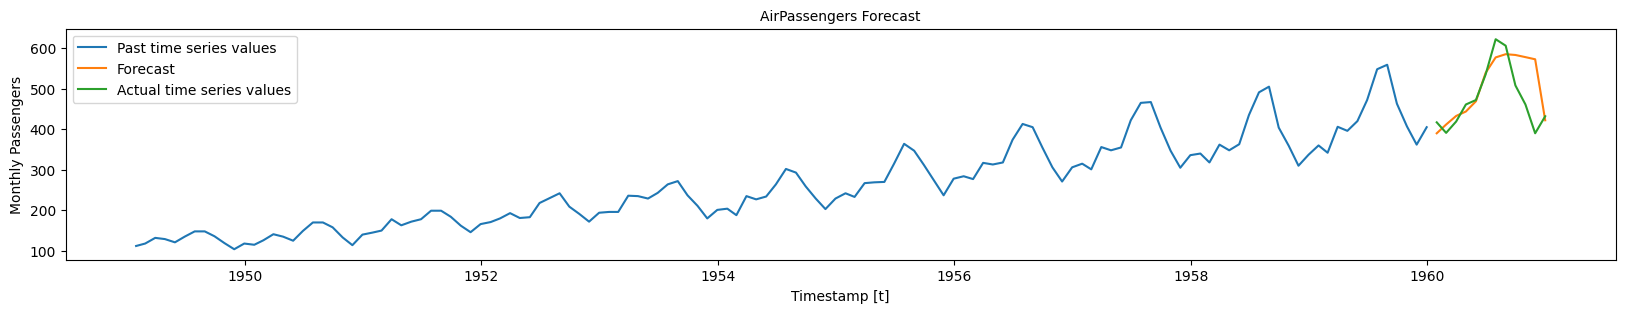

In [22]:
Y_train_df.set_index('ds',inplace =True)
forecasts.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = forecasts['VanillaTransformer']
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();